In [44]:
res = []

In [53]:
import pandas as pd
import numpy as np
# import pickle5 as pickle
import pickle
import urllib.request
import scipy.spatial.distance
import tensorflow as tf

# img load and show
from PIL import Image
import matplotlib.pyplot as plt

import re
# models
from keras.models import load_model, Model
from keras.applications import vgg16

#load cnn model
from tensorflow import keras
import os
import pickle

# color distributions
# from ImageFunctions import get_color_description, histogram
import cv2
import imutils
import sklearn.preprocessing as preprocessing

#img load
import requests
# !pip install fake_useragent
from fake_useragent import UserAgent 
from io import BytesIO
from PIL import Image

In [54]:

def show_image(img):
    
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.grid(False)
    plt.show()
    
def load_image(url):
    '''
    load an image from url, return image array
    '''
    ua = UserAgent()
    headers = {'user-agent': ua.random}

    response = requests.get(url, headers = headers)
    image_io = BytesIO(response.content)
    img = Image.open(image_io)    
    return np.array(img)
def get_color_description(img_array, bins):
    '''
    get color distribution feature vector for an image with specified number of bins
    split image up into 5 sections, 4 corners and a center ellipse, getting r,g, and b distribution vectors
    '''
    color = cv2.COLOR_BGR2HSV
    img = img_array * 255
    image = cv2.cvtColor(img, color)
    
    features = []
   
    # grab the dimensions and compute the center of the image
    (h, w) = image.shape[:2]
    (cX, cY) = (int(w * 0.5), int(h * 0.5))

    # divide the image into four rectangles/segments (top-left, top-right, bottom-right, bottom-left)
    segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h), (0, cX, cY, h)]

    # construct an elliptical mask representing the center of the image
    (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
    ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
    cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

    # loop over the segments
    for (startX, endX, startY, endY) in segments:
        # construct a mask for each corner of the image, subtracting the elliptical center from it
        cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
        cornerMask = cv2.subtract(cornerMask, ellipMask)

        # extract a color histogram from the image, then update the feature vector
        hist = histogram(image, cornerMask,bins)
        features.extend(hist)

        # extract a color histogram from the elliptical region and update the feature vector
        hist = histogram(image, ellipMask, bins)
        features.extend(hist)
    return features

def histogram(image, mask, bins):
    '''
    get histogram of reg, green, and blue color distribution feature vectors for a section of an image (represented by a mask)
    return 3 histograms as a single color feature vecotr
    '''
    # extract a 3D color histogram from the masked region of the image, using the supplied number of bins per channel
    hist = cv2.calcHist([image], [0,1,2], mask, [bins[0],bins[1],bins[2]],[0, 180, 0, 256, 0, 256])
    
    # normalize the histogram if we are using OpenCV 2.4
    if imutils.is_cv2():
        hist = cv2.normalize(hist).flatten()
        
    # otherwise handle for OpenCV 3+
    else:
        hist = cv2.normalize(hist, hist).flatten()

    return hist

Create vgg model

In [68]:
# create vgg model with correct input size
inputs = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=inputs)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

#dont want model weights to change durring training
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [56]:
# def load_data(img_class):
#     if img_class == 'parks':
#         aws_pathA = 'https://streamlit3.s3-us-west-2.amazonaws.com/parksA_df.pkl'
#         requests = urllib.request.urlopen(aws_pathA)
#         dfA = pickle.load(requests)
#         aws_pathB = 'https://streamlit3.s3-us-west-2.amazonaws.com/parksB_df.pkl'
#         requests = urllib.request.urlopen(aws_pathB)
#         dfB = pickle.load(requests)
#         return pd.concat([dfA, dfB])
#     else:
#         file_name = img_class.replace('/', '_')
#         #arn:aws:s3:::streamlit3
#         aws_path = 'https://streamlit3.s3-us-west-2.amazonaws.com/' + file_name +'_df.pkl'
#         local_path = 'C:/Users/prakruthimadhav/Documents/code red/travel/' + file_name + '_df.pkl'
#         requests = urllib.request.urlopen(aws_path)
#         df = pickle.load(requests)
#         # df = pickle.load(open(local_path, 'rb'))
#         return df

def load_data(img_class):
    # Load your DataFrame from the pickle file
    # Assuming you have a pickle file named 'img_att_loc_topics.pkl'
    df = pd.read_pickle('C:/Users/prakruthimadhav/Documents/code red/travel/Data/img_att_loc_topics_df.pkl')

    # Filter DataFrame based on the provided category (img_class)
    filtered_df = df[df['category'] == img_class]

    return filtered_df

def classify(img_vgg, model):
    '''
    find class using cnn model, using img vgg vector and return prediction
    '''
    cats = ['beaches/ocean', 'entertainment', 'gardens/zoo', 'landmarks', 'museums','parks']
    
    predictions = np.array(model.predict(img_vgg))
    print(predictions)
    pred = np.argmax(predictions) #find max value
    
    return cats[pred] 

def get_bottleneck_features(model, img_array):
    # Ensure the correct shape (1, 150, 150, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the input image for the VGG16 model
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    # Get the bottleneck features
    bottleneck_features = model.predict(img_array)

    # Reshape to (1, 8192) assuming the model is VGG16
    bottleneck_features_flat = bottleneck_features.flatten().reshape(1, -1)

    return bottleneck_features_flat

# def get_distance(img_feats, feats):
#     '''
#     get distance between vectors
#     '''
#     return scipy.spatial.distance.cosine(img_feats, feats)   
import numpy as np

def get_distance(img_feats, feats):
    '''
    Get distance between vectors.
    '''
    try:
        # Extract numeric features from the URLs or use the appropriate column
        # Replace this line with the correct logic based on your DataFrame structure
        numeric_feats = [float(x) for x in re.findall(r'\d+\.\d+|\d+', feats)]

        # Convert lists to NumPy arrays and flatten
        img_feats_flat = np.array(img_feats).astype(float).flatten()
        feats_flat = np.array(numeric_feats).astype(float).flatten()

        # Check if arrays are empty
        if img_feats_flat.size == 0 or feats_flat.size == 0:
            raise ValueError("One or both arrays are empty.")

        # Compute cosine distance
        return scipy.spatial.distance.cosine(img_feats_flat, feats_flat)
    except Exception as e:
        print(f"Error in get_distance: {e}")
        return np.nan  # or any other value to indicate an issue







def get_recommendations(img_class,img_array, img_vgg):
    '''
    get df of top attractions and siplay 3 images from top attractions
    '''
    # df = load_data()
    # load df with color and vgg descriptions
    df = load_data(img_class)
    print(df)


    #get color distribution feature vector
    bins = [8,8,8]
    img_color_des = get_color_description(img_array, bins)

    # get distances between color vectors of all imgs in class and distances between vgg vectors
    df['color_feats'] = df.apply(lambda row: get_distance(img_color_des, row[3]), axis=1)
    df['vgg_feats'] = df.apply(lambda row: get_distance(img_vgg, row[4]), axis=1)

    # create color and vgg vectors and standardize 
    min_max_scaler = preprocessing.MinMaxScaler()
    color_array = df['color_feats'].values.astype(float).reshape(-1,1)
    scaled_color_array = min_max_scaler.fit_transform(color_array)
   
    vgg_array = df['vgg_feats'].values.astype(float).reshape(-1,1)
    scaled_vgg_array = min_max_scaler.fit_transform(vgg_array)
    

    # drop color and vgg columns
    df.drop(['color_feats','vgg_feats'], axis=1, inplace=True)

    # combine arrays, weighing vgg vector depending on class
    if img_class in ['beaches/ocean']:
        total_distance =  0.5*scaled_vgg_array + scaled_color_array
    elif img_class in ['gardens/zoo']:
        total_distance =  10*scaled_vgg_array + scaled_color_array
    elif img_class in ['entertainment', 'landmarks', 'museums']:
        total_distance =  20*scaled_vgg_array + scaled_color_array
    else:
        total_distance =  1* scaled_vgg_array + scaled_color_array
   
    # add new distance column
    df['distance'] = total_distance

    # groupb attractions and find mean distance
    grouped_df = df.groupby(['name', 'location'])['distance'].mean()
    grouped_df = pd.DataFrame(grouped_df).reset_index()

    # remove attractins with no locations
    grouped_df['length'] = grouped_df.location.str.len()
    grouped_df = grouped_df[grouped_df.length > 3]

    # sort by distance ascending
    grouped_df.sort_values(by=['distance'], ascending=True, inplace=True)

    # get top 3 attractions
    top_df = grouped_df[:3].reset_index()
    atts = [top_df.loc[0,'name'], top_df.loc[1,'name'], top_df.loc[2,'name']]

    # groupp by attraction, and get groups for top 3 attractions
    grouped = df.groupby('name')
    groups = []
    for attraction in atts:
        groups.append(grouped.get_group(attraction))
    show_recommendations(groups, atts) #show recommendations

    return top_df
    

def show_recommendations(groups, atts):
    '''
    show 3 images for each recommended attraction
    '''
    for idx, group in enumerate(groups):
        df = pd.DataFrame(group).reset_index()
        imgs = [df.loc[1,'url'], df.loc[25,'url'], df.loc[19,'url']]
        fig = plt.figure()
        fig.suptitle(atts[idx], fontsize="x-large")
        for i in range(3):
            res.append([imgs[i]])
            a=fig.add_subplot(1,3,i+1)
            image = load_image(imgs[i])
            plt.imshow(image,cmap='Greys_r')
            plt.axis('off')

load model

In [57]:
model = load_model(r"C:\Users\prakruthimadhav\Documents\code red\trip\lets_take_a_trip-main\Notebooks\flask\vgg_cnn_final.h5")
# model = load_model('../Models/vgg_cnn_final.h5')
# model = load_model('../final_vgg_cnn.h5')

C:\Users\prakruthimadhav\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\prakruthimadhav\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


load test image

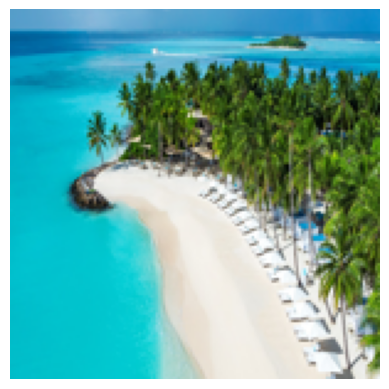

In [58]:
image = Image.open("C:/Users/prakruthimadhav/Documents/code red/trip/lets_take_a_trip-main/test_imgs/K.jpg") 
# image_sequence = an_image.getdata()
img = image.resize((150, 150)) 
img_array = np.array(img)
if len(img_array.shape) == 2:  # If the image is grayscale, convert to RGB
    img_array = np.stack((img_array,) * 3, axis=-1)
elif img_array.shape[-1] != 3:  # If the image has a different number of channels, raise an error
    print("error")

#show uploaded img
show_image(image_array)

In [59]:
# Ensure the correct shape (1, 150, 150, 3)
img_array = np.expand_dims(img_array, axis=0)
img_std = img_array / 255.0

# Remove singleton dimensions
img_std_copy = img_std.squeeze()

# Get bottleneck features
img_vgg = get_bottleneck_features(vgg_model, img_std_copy)
img_vgg_flattened = img_vgg.flatten().reshape(1, -1)

# Classify with the CNN model
label = classify(img_vgg_flattened, model)
print(label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[[2.9851930e-11 2.1086817e-04 7.3400308e-08 4.3116227e-13 2.0334834e-05
  1.4135170e-01]]
parks


                                    name                location category  \
464    Hugh S. Branyon Backcountry Trail  Orange Beach, AL 36561    parks   
465    Hugh S. Branyon Backcountry Trail  Orange Beach, AL 36561    parks   
466    Hugh S. Branyon Backcountry Trail  Orange Beach, AL 36561    parks   
467    Hugh S. Branyon Backcountry Trail  Orange Beach, AL 36561    parks   
468    Hugh S. Branyon Backcountry Trail  Orange Beach, AL 36561    parks   
...                                  ...                     ...      ...   
75105          Grand Teton National Park                 Wyoming    parks   
75106          Grand Teton National Park                 Wyoming    parks   
75107          Grand Teton National Park                 Wyoming    parks   
75108          Grand Teton National Park                 Wyoming    parks   
75109          Grand Teton National Park                 Wyoming    parks   

                                                     url  
464    https://d

Error in get_distance: operands could not be broadcast together with shapes (4096,) (7,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (8,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (9,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (7,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (8,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (7,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (8,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (8,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string o

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string o

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (7,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (7,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (7,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (8,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (8,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in g

C:\Users\prakruthimadhav\anaconda3\lib\site-packages\scipy\spatial\distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (2,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (7,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (7,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (7,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (3,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (5,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (6,) 
Error in get_distance: operands could not be broadcast together with shapes (4096,) (4,) 
Error in g

Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string or bytes-like object
Error in get_distance: expected string o

C:\Users\prakruthimadhav\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\prakruthimadhav\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


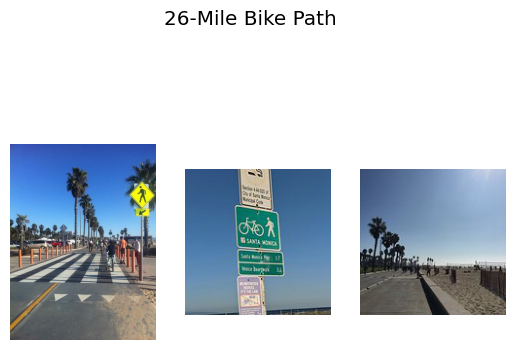

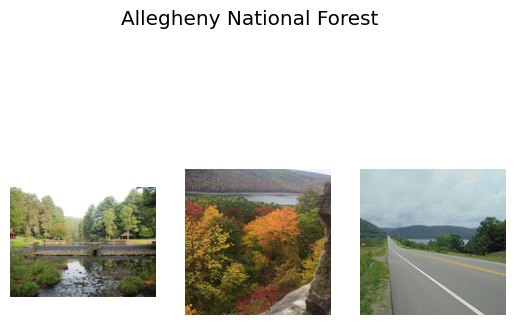

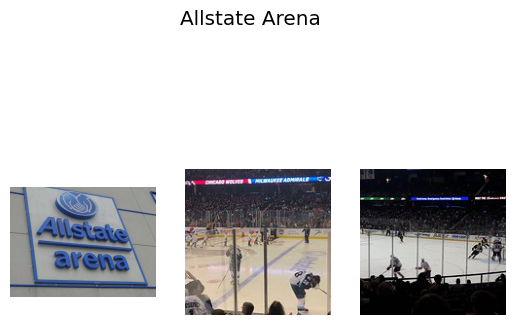

In [60]:
#get recommedations 
df = get_recommendations(label, image_array, img_vgg)


In [61]:
print(res[1])

['https://dynamic-media-cdn.tripadvisor.com/media/photo-o/03/a4/f7/b8/bicy-cross.jpg?w=700&h=600&s=1']


In [62]:
df

index                       name  \
0      0          26-Mile Bike Path   
1      1  Allegheny National Forest   
2      2             Allstate Arena   

                                    location  distance  length  
0                     Santa Monica, CA 90403       NaN      22  
1           Smokey Ln Off State Route 66, PA       NaN      32  
2  6920 Mannheim Rd, Rosemont, IL 60018-3622       NaN      41

In [63]:
n = len(df)
print(type(res))
print(type(n))
df.iloc[0,1]

<class 'list'>
<class 'int'>


'26-Mile Bike Path'

In [65]:
dict1 = {}
for i in range(n):
    name = df.iloc[i,1]
    dict1[name] = res[i:i+3]
print(dict1)

{'26-Mile Bike Path': [['https://dynamic-media-cdn.tripadvisor.com/media/photo-o/03/a4/f7/b8/bicy-cross.jpg?w=700&h=600&s=1'], ['https://dynamic-media-cdn.tripadvisor.com/media/photo-o/03/a4/f7/b8/bicy-cross.jpg?w=700&h=600&s=1'], ['https://media-cdn.tripadvisor.com/media/photo-l/19/a7/9f/a4/img-20191006-174654-largejpg.jpg']], 'Allegheny National Forest': [['https://dynamic-media-cdn.tripadvisor.com/media/photo-o/03/a4/f7/b8/bicy-cross.jpg?w=700&h=600&s=1'], ['https://media-cdn.tripadvisor.com/media/photo-l/19/a7/9f/a4/img-20191006-174654-largejpg.jpg'], ['https://media-cdn.tripadvisor.com/media/photo-l/1a/60/62/69/photo2jpg.jpg']], 'Allstate Arena': [['https://media-cdn.tripadvisor.com/media/photo-l/19/a7/9f/a4/img-20191006-174654-largejpg.jpg'], ['https://media-cdn.tripadvisor.com/media/photo-l/1a/60/62/69/photo2jpg.jpg'], ['https://dynamic-media-cdn.tripadvisor.com/media/photo-o/02/e0/71/3a/allegheny-national-forest.jpg?w=1000&h=-1&s=1']]}


In [66]:
import json 
# Convert and write JSON object to file
with open("samp.json", "w") as outfile: 
    json.dump(dict1, outfile)

In [20]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [22]:
import tensorflow as tf


In [24]:
model.save('model.h5')

In [25]:
loaded_model = tf.keras.models.load_model('model.h5')